In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

In [3]:
def normalize_features(X, mean=None, std=None):
    X_norm = X.copy()
    if mean is None:
        mean = np.mean(X[:, 1:], axis=0)
        std = np.std(X[:, 1:], axis=0)
        std[std == 0] = 1.0
    X_norm[:, 1:] = (X[:, 1:] - mean) / std
    return X_norm, mean, std

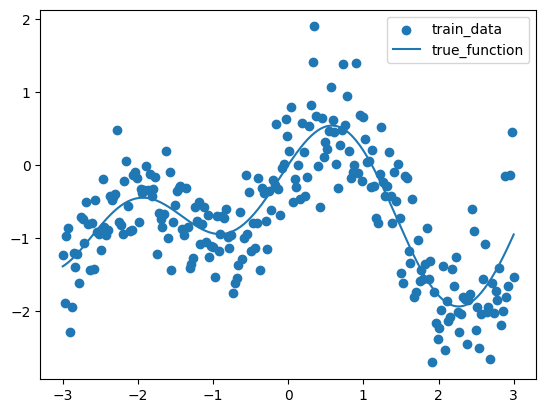

In [4]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

X_norm, X_mean, X_std = normalize_features(X)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [5]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X_norm.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X_norm.T @ X_norm)

In [6]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X_norm.T @ y)

In [7]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)
X_new_norm, _, _ = normalize_features(X_new, mean=X_mean, std=X_std)

mean_pred = X_new_norm @ mean
var_pred = 1.0 / alpha + np.sum((X_new_norm @ posterior_cov) * X_new_norm, axis=1)
std_pred = np.sqrt(var_pred)

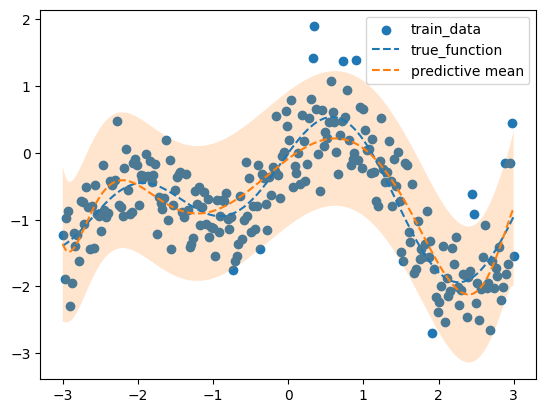

In [8]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [9]:
np.mean((f_true(x_new) - mean_pred) ** 2) # mse w/ lamb=1

0.03092733995563723

In [10]:
def log_evidence(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''
    n = X.shape[0]
    
    sigmasq = 1 / alpha
    tausq = sigmasq / lamb
    C = sigmasq * np.eye(n) + tausq * (X @ X.T)
    
    sgn, logdetC = np.linalg.slogdet(C)
    if sgn <= 0: 
        return -np.inf
    
    invC = np.linalg.inv(C)
    logev = (-1/2) * (n * np.log(2 * np.pi) + logdetC + y.T @ invC @ y)
    
    return logev

In [22]:
lambs = np.logspace(-5, 5, 1000)

logevs = []
for lamb in lambs:
    logev = log_evidence(lamb, X_norm, y, alpha)
    logevs.append(logev)

logevs = np.array(logevs)

In [23]:
best_idx = np.argmax(logevs)
best_lamb = lambs[best_idx]
best_logev = logevs[best_idx]

In [24]:
best_lamb

0.019646866461804465

In [25]:
best_logev

-205.3906237855652

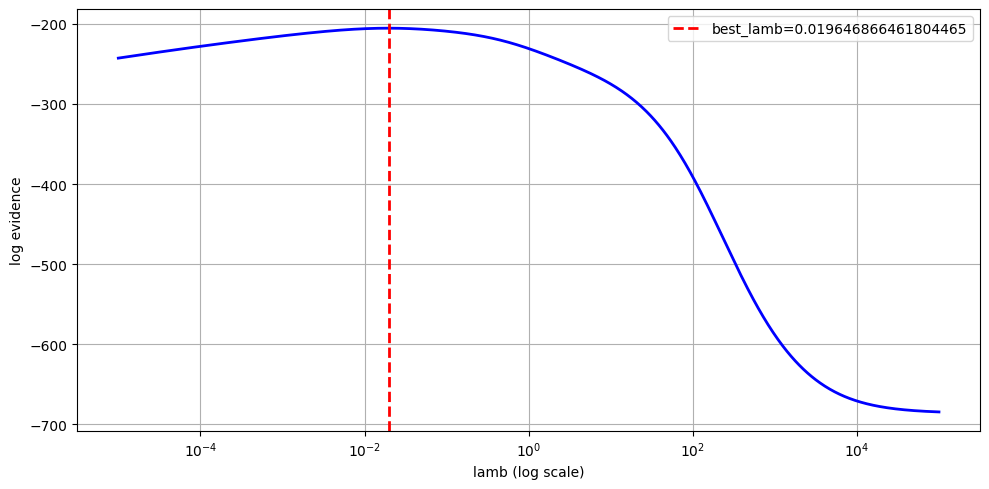

In [27]:
plt.figure(figsize=(10, 5))
plt.semilogx(lambs, logevs, 'b-', linewidth=2)
plt.axvline(best_lamb, color='r', linestyle='--', linewidth=2, label=f'{best_lamb=}')
plt.xlabel('lamb (log scale)')
plt.ylabel('log evidence')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
lamb = best_lamb
alpha = 1.0 / (sigma ** 2)

M = X_norm.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X_norm.T @ X_norm)

In [29]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X_norm.T @ y)

In [30]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)
X_new_norm, _, _ = normalize_features(X_new, mean=X_mean, std=X_std)

mean_pred = X_new_norm @ mean
var_pred = 1.0 / alpha + np.sum((X_new_norm @ posterior_cov) * X_new_norm, axis=1)
std_pred = np.sqrt(var_pred)

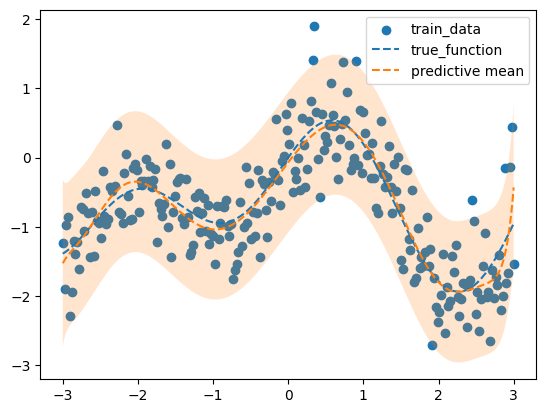

In [31]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [32]:
np.mean((f_true(x_new) - mean_pred) ** 2) # mse w/ lamb=best_lamb

0.008505313058980116